# Dataset Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## File and Data Field Descriptions

### train.csv
Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### test.csv
Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

### sample_submission.csv
A submission file in the correct format.
- **PassengerId** - Id for each passenger in the test set.
- **Transported** - The target. For each passenger, predict either True or False.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
train_data = pd.read_csv('data/train.csv')

# Display the first few rows of the dataset
train_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [80]:
# Remove columns with no correlation to the target variable
train_data = train_data.drop(columns=['Name', 'PassengerId'])

# Display the first few rows of the updated dataset
train_data.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [81]:
# Data preprocessing
# Handle missing values
train_data = train_data.fillna({
    'HomePlanet': train_data['HomePlanet'].mode()[0],
    'CryoSleep': train_data['CryoSleep'].mode()[0],
    'Cabin': train_data['Cabin'].mode()[0],
    'Destination': train_data['Destination'].mode()[0],
    'Age': train_data['Age'].median(),
    'VIP': train_data['VIP'].mode()[0],
    'RoomService': 0,
    'FoodCourt': 0,
    'ShoppingMall': 0,
    'Spa': 0,
    'VRDeck': 0
})

train_data.head(5)

/var/folders/8b/8ktrkt992xx9kcyjf8n9b2340000gn/T/ipykernel_94446/1021741803.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data = train_data.fillna({


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [82]:
# Extract cabin features
train_data[['Deck', 'Num', 'Side']] = train_data['Cabin'].str.split('/', expand=True)

# Drop the cabin column
train_data = train_data.drop(columns=['Cabin'])

train_data.head(5)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [83]:
# Convert boolean to numeric
train_data['CryoSleepNum'] = train_data['CryoSleep'].astype(int)
train_data['VIPNum'] = train_data['VIP'].astype(int)
train_data['TransportedNum'] = train_data['Transported'].astype(int)

train_data = train_data.drop(columns=['CryoSleep', 'VIP'])

train_data.head(5)

,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,CryoSleepNum,VIPNum,TransportedNum
0,Europa,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0,0,0
1,Earth,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S,0,0,1
2,Europa,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,0,1,0
3,Europa,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,0,0,0
4,Earth,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S,0,0,1


In [84]:
# One-hot encode categorical features
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
train_data_encoded = pd.get_dummies(train_data, columns=categorical_cols)
train_data_encoded.head(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,CryoSleepNum,VIPNum,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,0,0,...,False,True,False,False,False,False,False,False,True,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0,0,0,...,False,False,False,False,False,True,False,False,False,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,0,1,...,True,False,False,False,False,False,False,False,False,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,0,0,...,True,False,False,False,False,False,False,False,False,True
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,...,False,False,False,False,False,True,False,False,False,True


In [85]:
# Select features and target
X = train_data_encoded.drop(['Transported', 'TransportedNum', 'Num'], axis=1)
y = train_data_encoded['TransportedNum']

y.head(5)

0    0
1    1
2    0
3    0
4    1
Name: TransportedNum, dtype: int64

In [86]:
# Split the data

from sklearn.model_selection import train_test_split

#X_train and y_train are the training data
#X_val and y_val are the cross validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [101]:
# PyTorch Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.unsqueeze(1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

class SpaceshipNN(nn.Module):
    def __init__(self, input_size):
        super(SpaceshipNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128) # ADDED
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3) # ADJUSTED from 0.5

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # ADDED

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)   # ADDED

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x))) # BN before ReLU
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x))) # BN before ReLU
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x))) # BN before ReLU
        # x = self.dropout(x) # Often no dropout before the final output layer
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Initialize the model
input_size = X_train_scaled.shape[1]
model = SpaceshipNN(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
num_epochs = 200

train_losses = []
val_losses = []
val_accuracies = []

# Before your training loop:
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 15  # e.g., 10-20 epochs
early_stop_epoch = num_epochs # To keep track for plotting

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = running_loss / len(val_loader.dataset)

    # Inside your training loop, after calculating epoch_val_loss:
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth') # Save best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after epoch {epoch + 1}')
        early_stop_epoch = epoch + 1
        break

    epoch_val_accuracy = correct / total
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Print statistics
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}')
        print(f'Val Accuracy: {epoch_val_accuracy:.4f}')
        print('-' * 30)

Epoch 5/200:
Train Loss: 0.4337
Val Loss: 0.4314
Val Accuracy: 0.7947
------------------------------
Epoch 10/200:
Train Loss: 0.4274
Val Loss: 0.4278
Val Accuracy: 0.7901
------------------------------
Epoch 15/200:
Train Loss: 0.4226
Val Loss: 0.4250
Val Accuracy: 0.7890
------------------------------
Epoch 20/200:
Train Loss: 0.4229
Val Loss: 0.4260
Val Accuracy: 0.7832
------------------------------
Epoch 25/200:
Train Loss: 0.4208
Val Loss: 0.4241
Val Accuracy: 0.7959
------------------------------
Epoch 30/200:
Train Loss: 0.4198
Val Loss: 0.4250
Val Accuracy: 0.7878
------------------------------
Epoch 35/200:
Train Loss: 0.4192
Val Loss: 0.4233
Val Accuracy: 0.7901
------------------------------
Epoch 40/200:
Train Loss: 0.4211
Val Loss: 0.4281
Val Accuracy: 0.7878
------------------------------
Epoch 45/200:
Train Loss: 0.4202
Val Loss: 0.4282
Val Accuracy: 0.7924
------------------------------
Epoch 50/200:
Train Loss: 0.4148
Val Loss: 0.4313
Val Accuracy: 0.7867
------------

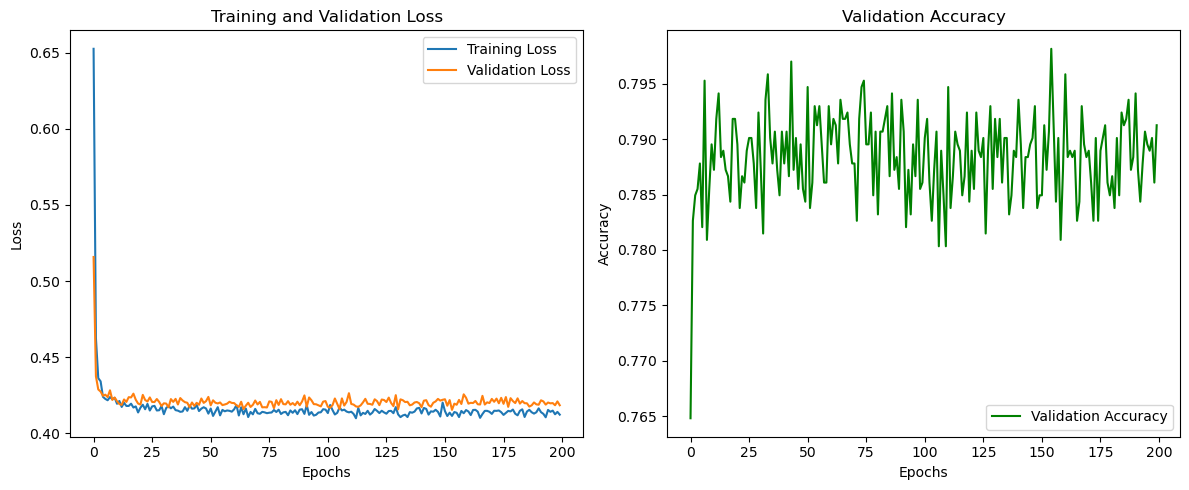

In [99]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
## Generate a submission file sample_submission_ashwanth.csv

# Load the test data
test_data = pd.read_csv('data/test.csv')

# Save PassengerId for submission
passenger_ids = test_data['PassengerId']

# Preprocess the test data
test_data = test_data.drop(columns=['Name', 'PassengerId'])

# Extract cabin information
test_data[['Deck', 'Num', 'Side']] = test_data['Cabin'].str.split('/', expand=True)
# Fix: Handle NaN values properly when converting to numeric
test_data['Num'] = pd.to_numeric(test_data['Num'], errors='coerce').fillna(0).astype(int)

# Fill NaN values in boolean columns before converting to numeric
test_data['CryoSleep'] = test_data['CryoSleep'].fillna(False)
test_data['VIP'] = test_data['VIP'].fillna(False)

# Convert boolean columns to numeric
test_data['CryoSleepNum'] = test_data['CryoSleep'].astype(int)
test_data['VIPNum'] = test_data['VIP'].astype(int)

# Fill NaN values in other columns
for col in test_data.columns:
    if test_data[col].dtype == 'float64':
        test_data[col] = test_data[col].fillna(0)
    elif test_data[col].dtype == 'object':
        test_data[col] = test_data[col].fillna('Unknown')

# One-hot encode categorical features
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side']
test_data_encoded = pd.get_dummies(test_data, columns=categorical_features)

# Make sure all columns from training data are present
for col in X_train.columns:
    if col not in test_data_encoded.columns:
        test_data_encoded[col] = 0

# Select only the features used in training
X_test = test_data_encoded[X_train.columns]

# Scale the features
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).bool()

# Create a submission file
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': predicted.squeeze().numpy()
})

submission.to_csv('sample_submission_ashwanth.csv', index=False)


/var/folders/8b/8ktrkt992xx9kcyjf8n9b2340000gn/T/ipykernel_94446/1616245224.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data['CryoSleep'] = test_data['CryoSleep'].fillna(False)
/var/folders/8b/8ktrkt992xx9kcyjf8n9b2340000gn/T/ipykernel_94446/1616245224.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data['VIP'] = test_data['VIP'].fillna(False)
